In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrna

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import tqdm

/home/ing/miniconda3/envs/scrna/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
paths = [
    'scvelo_timevectors_normalA.csv',
    'scvelo_timevectors_normalB.csv',
    'scvelo_timevectors_normalC.csv',
    'scvelo_timevectors_normalD.csv',
]
normal_time = []
for pth in paths:
    x = pd.read_csv(pth, index_col=0, header=0)
    normal_time.append(x.copy())
    
normal_time = pd.concat(normal_time, axis=0)
print(normal_time.shape)

(12819, 2)


,velocity_pseudotime,latent_time
A__AACACACCAAAGCTCT,0.994248,0.752954
A__AAAGGTACAAGGCGTA,0.981214,0.711687
A__AAAGGGCGTGGGATTG,0.989378,0.703129
A__AACAAGAAGATGGTAT,0.454420,0.126090
A__AAAGAACGTGCATGAG,0.991021,0.750117
...,...,...
D__TTTGGTTTCCACTGAA,0.358171,0.674326
D__TTTGGTTGTATGGTAA,0.439041,0.819907
D__TTTGACTGTCAAGCCC,0.622234,0.766350
D__TTTGTTGTCGCTTGCT,0.188469,0.148580


In [3]:
paths = [
    'scvelo_heatmap__normalA.png.genes.txt',
    'scvelo_heatmap__normalB.png.genes.txt',
    'scvelo_heatmap__normalC.png.genes.txt',
    'scvelo_heatmap__normalD.png.genes.txt',
]
latent_time_genes = []
for pth in paths:
    genes = [l.strip() for l in open(pth, 'r')]
    print(len(genes))
    latent_time_genes += genes
    
latent_time_genes = np.unique(latent_time_genes)
print(len(latent_time_genes))

500
500
500
500
1118


In [4]:
"""
This block loads GEX from a shared h5ad file. it is replaced by simply loading the individual 
GEX from separate MIBC and non-tumor datasets
"""

# ad = sc.read_h5ad('combo_Tumor_Normal.clust.h5ad')
# ad.obsm['X_umap'] = ad.obsm['X_scVI_umap_vanilla']
# print(ad.shape)

# sc.pp.normalize_total(ad, target_sum=10000)
# sc.pp.log1p(ad)

# ad = ad[:, latent_time_genes]
# # ad = ad[use_barcodes]
# print(ad.shape)

# ad_tumor = ad[(ad.obs.cohort == 'tumor') & (ad.obs.BroadCellType_v2 == 'Epithelial')]
# ad_normal = ad[normal_time.index]
# ad_normal.obs[normal_time.columns] = normal_time
# print(ad_tumor.shape, ad_normal.shape)

(93090, 33538)
(93090, 1118)


/home/ing/miniconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/home/ing/miniconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


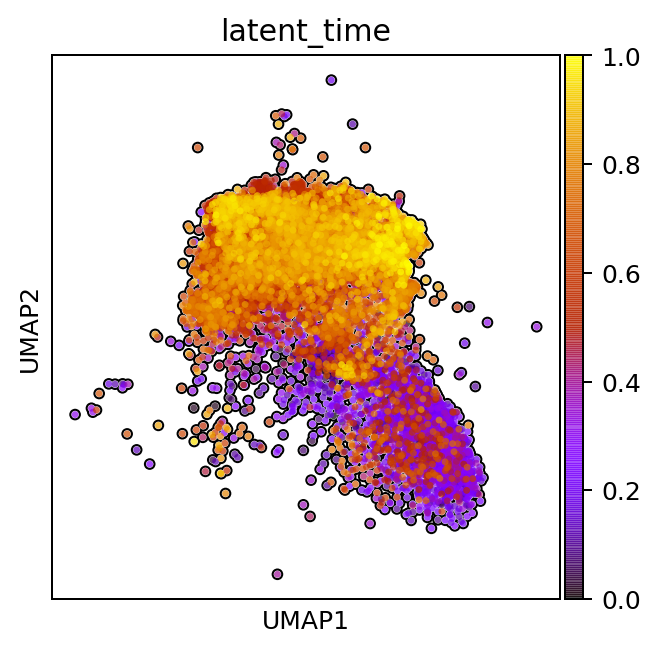

In [6]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 180
rcParams['figure.figsize'] = (4,4)
sc.pl.umap(ad_normal, color='latent_time', cmap='gnuplot', s=30, add_outline=True)

# Run the nearest neighbor search matching tumor cells with normal cells

In [7]:
x_normal = ad_normal.X.toarray()

In [8]:
nearest_cells = np.zeros(ad_tumor.shape[0], dtype=np.int32)
# %%timeit
for i in tqdm.notebook.tnrange(ad_tumor.shape[0]):
# i = np.random.choice(ad_tumor.shape[0])
    tumor_cell = np.squeeze(ad_tumor[i, :].X.toarray())
    dist = np.linalg.norm(x_normal - tumor_cell, ord=1, axis=1)
    srt = np.argsort(dist)
    nearest_cells[i] = srt[0]

In [9]:
nearest_cell_barcodes = np.zeros(ad_tumor.shape[0], dtype=object)
nn_latent_time = np.zeros(ad_tumor.shape[0], dtype=np.float32)
for i,k in enumerate(nearest_cells):
    nearest_cell_barcodes[i] = normal_time.index[k]
    nn_latent_time[i] = normal_time.iloc[k, 1]

In [20]:
ad_tumor.obs['nn_latent_time'] = nn_latent_time
ad_tumor.obs['nn_barcodes'] = nearest_cell_barcodes
# ad_tumor.obs['L1_nn_latent_time'] = L1_nn_latent_time

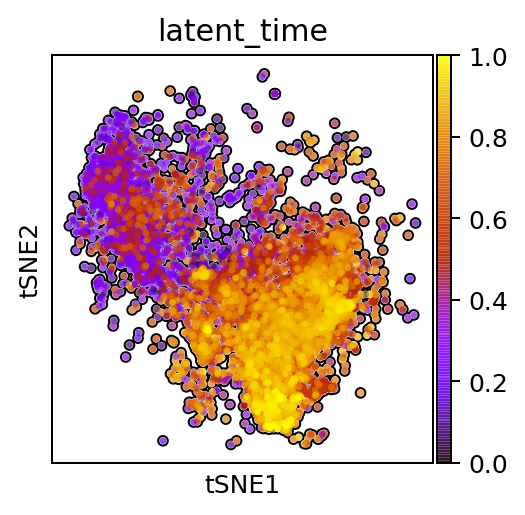

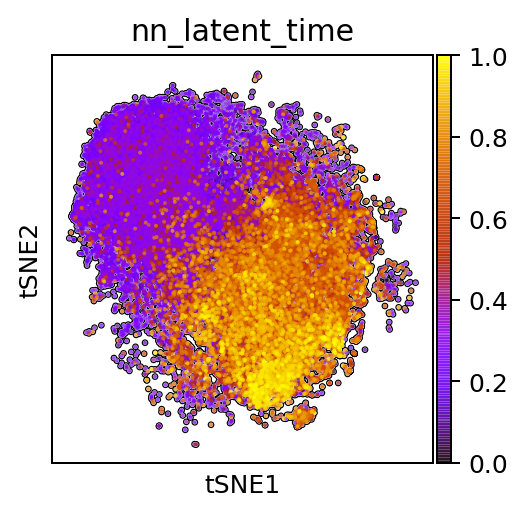

In [11]:
ad_normal.obsm['X_tsne'] = ad_normal.obsm['X_scVI_tsne_vanilla']
ad_tumor.obsm['X_tsne'] = ad_tumor.obsm['X_scVI_tsne_vanilla']

rcParams['figure.dpi'] = 180
rcParams['figure.figsize'] = (3,3)
sc.pl.tsne(ad_normal, color='latent_time', cmap='gnuplot', s=30, add_outline=True, 
#            save='_normal_latent_time.png'
          )
sc.pl.tsne(ad_tumor, color='nn_latent_time', cmap='gnuplot', s=10, add_outline=True,
#            save='_tumor_nn_latent_time.png' 
          )
# sc.pl.umap(ad_tumor, color='L1_nn_latent_time', cmap='gnuplot', s=10, add_outline=True)


In [13]:
normal_st = ad_normal.obs.SubType_combined
nearest_normal_type = np.zeros_like(nearest_cell_barcodes)
for i, bc in enumerate(nearest_cell_barcodes):
    nearest_normal_type[i] = normal_st[bc]

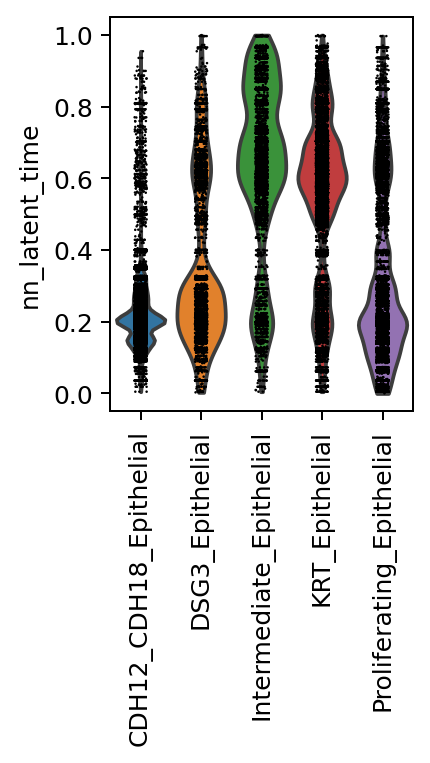

In [12]:
sc.pl.violin(ad_tumor, 'nn_latent_time', groupby='SubType_v3', rotation=90, 
#              save='_tumor_nearest_neighbor_latent_time.png'
            )

In [21]:
df = ad_tumor.obs.loc[:, ['SubType_combined', 'nn_latent_time', 'nn_barcodes']]
df['nearest_normal_type'] = nearest_normal_type
df.to_csv('tumor_nearest_neighbor_latent_time_AllNormalSamples_v2.csv')
df

,SubType_combined,nn_latent_time,nn_barcodes,nearest_normal_type
B1__AAACCCAAGAGTAACT,CDH12_CDH18_Epithelial,0.224133,D__GAGCCTGCAATCCTTT,Normal_CDH12
B1__AAACCCAAGCGGACAT,CDH12_CDH18_Epithelial,0.193314,D__GGCTTGGCAAATTGCC,Normal_CDH12
B1__AAACCCAAGTGCCGAA,KRT_Epithelial,0.849366,A__ATGAGTCGTTGACGGA,Normal_Umbrella_Intermediate
B1__AAACCCACAAAGAGTT,DSG3_Epithelial,0.145237,D__TTCTAGTAGAGATTCA,Normal_CDH12
B1__AAACCCACAAGCTACT,KRT_Epithelial,0.680381,A__TCCTCCCTCAAGAGTA,Normal_Umbrella_Intermediate
...,...,...,...,...
B8B__TTTCACAAGGTTCCGC,CDH12_CDH18_Epithelial,0.125478,D__ATGGAGGAGCGTGCCT,Normal_CDH12
B8B__TTTCATGTCACTCCGT,CDH12_CDH18_Epithelial,0.211906,D__AGGGAGTTCTTAGGAC,Normal_CDH12
B8B__TTTCCTCTCACCTGTC,Proliferating_Epithelial,0.392664,C__TTCCTCTCAACGGCTC,Normal_CDH12
B8B__TTTCGATAGAATTCAG,KRT_Epithelial,0.193696,D__AACCAACTCGTGGCGT,Normal_CDH12
